# Setting up

In [1]:
# %pip install matplotlib
# %pip install tensorflow==2.14.0
# %pip install innvestigate==2.1.2

In [2]:
import tensorflow as tf
import warnings
tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')

# Reconstruct Model

## Define the architecture that was made before

In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


## Load the saved weight

In [4]:
model.load_weights('../src/models/res_net_model_weight.h5')

## Check classification result

### Load images

In [5]:
import os
from glob import glob

dataset_path = "../data/test"
num_images = 10
selected_images = []
class_name = []

exclude = ['Neck_Blast', 'Rice Hispa']

for cls_name in sorted(os.listdir(dataset_path)):
    if cls_name not in exclude:
        cls_path = os.path.join(dataset_path, cls_name)
        if os.path.isdir(cls_path):
            images = sorted(glob(os.path.join(cls_path, "*.jpg")))
            selected_images.extend(images[:num_images])
            class_name.extend([cls_name] * num_images)

print("Total selected:", len(selected_images))
print("Classes:", class_name)

Total selected: 70
Classes: ['Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Bacterial Leaf Blight', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf Blast', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Narrow Brown Leaf Spot', 'Narrow Brown Leaf Spot', 'Narrow Brown

### Encode Label

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

class_name = label_encoder.fit_transform(class_name)
classes = label_encoder.classes_

print("Encoded class label:", class_name)
print("Decoded class label:", classes)

Encoded class label: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6]
Decoded class label: ['Bacterial Leaf Blight' 'Brown Spot' 'Healthy Rice Leaf' 'Leaf Blast'
 'Leaf scald' 'Narrow Brown Leaf Spot' 'Sheath Blight']


### Preprocess image

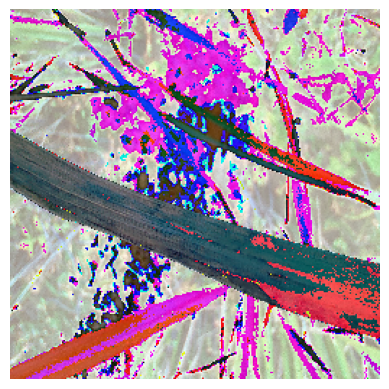

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

image_array = []

for img_path in selected_images:
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    image_array.append(img_array)

image_array = np.array(image_array)
np.save('../src/image_array/image_array.npy', image_array)

# Show sample image
plt.imshow(image_array[0].astype('uint8'))
plt.axis('off')
plt.show()

## Check original image

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess_resnet(x):
    """Deprocess image that used keras.applications.resnet.preprocess_input"""
    x = x.copy()
    mean = [103.939, 116.779, 123.68]  # BGR, From ImageNet mean
    # Return values using mean
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    # Reverse BGR tp RGB
    x = x[..., ::-1]
    # Make sure that the values are in [0-255]
    return np.clip(x, 0, 255).astype("uint8")

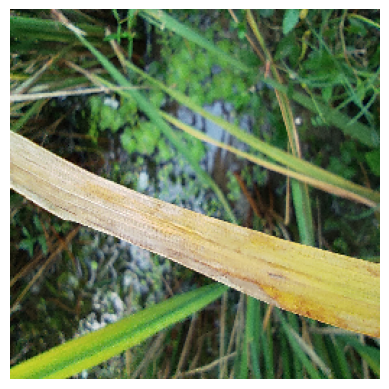

In [9]:
plt.imshow(deprocess_resnet(image_array[0]))
plt.axis("off")
plt.show()

In [10]:
y_pred = model.predict(image_array)
y_pred_classes = np.argmax(y_pred,axis=1)
y_pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3, 3, 3, 0, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 4, 6, 0], dtype=int64)

In [11]:
from sklearn.metrics import classification_report

print(classification_report(class_name, y_pred_classes, target_names=classes))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.83      1.00      0.91        10
            Brown Spot       1.00      0.90      0.95        10
     Healthy Rice Leaf       0.91      1.00      0.95        10
            Leaf Blast       1.00      0.80      0.89        10
            Leaf scald       0.83      1.00      0.91        10
Narrow Brown Leaf Spot       1.00      1.00      1.00        10
         Sheath Blight       1.00      0.80      0.89        10

              accuracy                           0.93        70
             macro avg       0.94      0.93      0.93        70
          weighted avg       0.94      0.93      0.93        70



## Remove softmax

In [12]:
import innvestigate

model_wo_softmax = innvestigate.model_wo_softmax(model)
model_wo_softmax.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Create LRP analyzer

## Define rules

In [13]:
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRP
import innvestigate.analyzer.relevance_based.relevance_rule as rrule
import tensorflow.keras.layers as klayers

class EpsilonProxyRule(rrule.EpsilonRule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, epsilon=0.1, bias=True, **kwargs)

CONV_LAYERS = (
    klayers.Conv1D,
    klayers.Conv2D,
    klayers.Conv2DTranspose,
    klayers.Conv3D,
    klayers.Conv3DTranspose,
    klayers.SeparableConv1D,
    klayers.SeparableConv2D,
    klayers.DepthwiseConv2D,
)

PASS_LAYERS = (
    klayers.Activation,
    klayers.Flatten,
    klayers.Dropout,
    klayers.Add,
    klayers.MaxPooling1D,
    klayers.MaxPooling2D,
    klayers.MaxPooling3D,
    klayers.AveragePooling1D,
    klayers.AveragePooling2D,
    klayers.AveragePooling3D,
    klayers.GlobalAveragePooling1D,
    klayers.GlobalAveragePooling2D,
    klayers.GlobalAveragePooling3D,
    klayers.GlobalMaxPooling1D,
    klayers.GlobalMaxPooling2D,
    klayers.GlobalMaxPooling3D,
    klayers.ZeroPadding1D,
    klayers.ZeroPadding2D,
    klayers.ZeroPadding3D,
    klayers.Cropping1D,
    klayers.Cropping2D,
    klayers.Cropping3D,
)

rules = [
    (lambda layer: isinstance(layer, klayers.Dense), EpsilonProxyRule),
    (lambda layer: isinstance(layer, CONV_LAYERS), rrule.Alpha2Beta1Rule),
    (lambda layer: isinstance(layer, PASS_LAYERS), 'Pass'),
]

In [14]:
analyzer = LRP(model_wo_softmax, rule=rules, input_layer_rule=rrule.FlatRule, bn_layer_rule=rrule.AlphaBetaX2m100Rule)

# Get Relevance Heatmap

In [15]:
relevance = []

for idx in range(len(classes)):
    start = idx * num_images
    end = start + num_images
    print(f'Analyzing {classes[idx]}, index: [{start}:{end}]')
    r = analyzer.analyze(image_array[start:end])
    print(f'Finished analyzing {classes[idx]}')
    relevance.extend(r)
    del r

relevance = np.array(relevance)
np.save('../src/image_array/lrp_relevance_score.npy', relevance)

Analyzing Bacterial Leaf Blight, index: [0:10]
Finished analyzing Bacterial Leaf Blight
Analyzing Brown Spot, index: [10:20]
Finished analyzing Brown Spot
Analyzing Healthy Rice Leaf, index: [20:30]
Finished analyzing Healthy Rice Leaf
Analyzing Leaf Blast, index: [30:40]
Finished analyzing Leaf Blast
Analyzing Leaf scald, index: [40:50]
Finished analyzing Leaf scald
Analyzing Narrow Brown Leaf Spot, index: [50:60]
Finished analyzing Narrow Brown Leaf Spot
Analyzing Sheath Blight, index: [60:70]
Finished analyzing Sheath Blight


# LRP Visualization

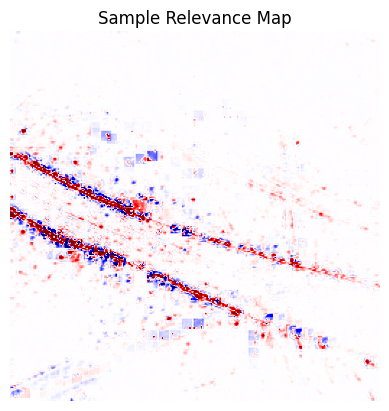

In [16]:
import numpy as np
import matplotlib.pyplot as plt

relevance_map = []

for rel in relevance:
    # sum channel
    rel_map = rel.sum(axis=-1)
    
    # take 99th percentile
    vmax = np.percentile(np.abs(rel_map), 99)
    
    # clip & normalize
    rel_map = np.clip(rel_map, -vmax, vmax)
    rel_map /= vmax

    relevance_map.append(rel_map)

relevance_map = np.array(relevance_map)
np.save('../src/image_array/lrp_relevance_map.npy', relevance_map)

# plot
plt.imshow(relevance_map[0], cmap="seismic", clim=(-1, 1))
plt.title(f"Sample Relevance Map")
plt.axis("off")
plt.show()

# Occlude Sample Image

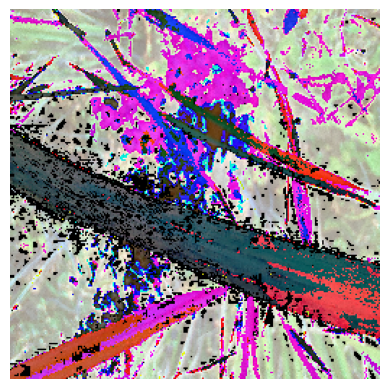

In [17]:
import matplotlib.pyplot as plt

occluded_img = []

for img_array, rel_map in zip(image_array, relevance_map):
    # Take top 10% relevant
    threshold = np.percentile(rel_map, 90)

    mask = np.ones_like(img_array)
    mask[rel_map >= threshold, :] = 0

    occluded = img_array * mask
    # occluded = np.expand_dims(occluded, axis=0)

    occluded_img.append(occluded)

occluded_img = np.array(occluded_img)
np.save('../src/image_array/occluded_image_array.npy', occluded_img)

plt.imshow(occluded_img[0].astype('uint8'))
plt.axis('off')
plt.show()

## Check original image

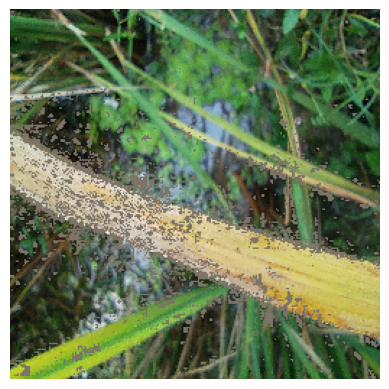

In [18]:
plt.imshow(deprocess_resnet(occluded_img[0]))
plt.axis("off")
plt.show()

# Occluded Image Prediction

In [19]:
occluded_y_pred = model.predict(occluded_img)
occluded_y_pred_classes = np.argmax(occluded_y_pred, axis=1)
occluded_y_pred_classes

array([4, 6, 6, 4, 4, 4, 5, 6, 2, 2, 2, 1, 2, 1, 3, 1, 5, 3, 2, 1, 2, 2,
       2, 2, 6, 2, 2, 1, 2, 2, 2, 4, 2, 4, 5, 3, 3, 4, 6, 6, 6, 4, 4, 2,
       4, 4, 2, 4, 6, 4, 4, 5, 4, 6, 5, 5, 5, 4, 5, 1, 6, 6, 4, 6, 6, 4,
       6, 6, 6, 6], dtype=int64)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(class_name, occluded_y_pred_classes, target_names=classes))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.00      0.00      0.00        10
            Brown Spot       0.67      0.40      0.50        10
     Healthy Rice Leaf       0.47      0.80      0.59        10
            Leaf Blast       0.50      0.20      0.29        10
            Leaf scald       0.33      0.60      0.43        10
Narrow Brown Leaf Spot       0.62      0.50      0.56        10
         Sheath Blight       0.47      0.80      0.59        10

              accuracy                           0.47        70
             macro avg       0.44      0.47      0.42        70
          weighted avg       0.44      0.47      0.42        70



# Get Relevance Heatmap

In [21]:
occluded_relevance = []

for idx in range(len(classes)):
    start = idx * num_images
    end = start + num_images
    print(f'Analyzing {classes[idx]}, index: [{start}:{end}]')
    r = analyzer.analyze(occluded_img[start:end])
    print(f'Finished analyzing {classes[idx]}')
    occluded_relevance.extend(r)
    del r

occluded_relevance = np.array(occluded_relevance)
np.save('../src/image_array/occluded_lrp_relevance_score.npy', occluded_relevance)

Analyzing Bacterial Leaf Blight, index: [0:10]
Finished analyzing Bacterial Leaf Blight
Analyzing Brown Spot, index: [10:20]
Finished analyzing Brown Spot
Analyzing Healthy Rice Leaf, index: [20:30]
Finished analyzing Healthy Rice Leaf
Analyzing Leaf Blast, index: [30:40]
Finished analyzing Leaf Blast
Analyzing Leaf scald, index: [40:50]
Finished analyzing Leaf scald
Analyzing Narrow Brown Leaf Spot, index: [50:60]
Finished analyzing Narrow Brown Leaf Spot
Analyzing Sheath Blight, index: [60:70]
Finished analyzing Sheath Blight


# Get Relevance Heatmap

# LRP Visualization

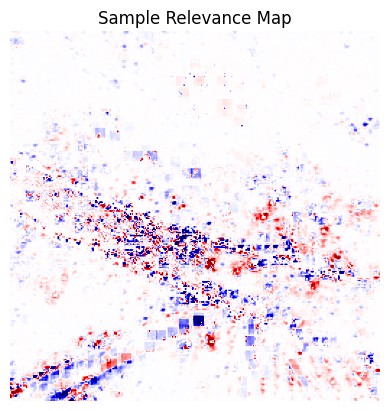

In [22]:
import numpy as np
import matplotlib.pyplot as plt

occluded_relevance_map = []

for occluded_rel in occluded_relevance:
    # sum channel
    occluded_rel_map = occluded_rel.sum(axis=-1)
    
    # take 99th percentile
    vmax = np.percentile(np.abs(occluded_rel_map), 99)
    
    # clip & normalize
    occluded_rel_map = np.clip(occluded_rel_map, -vmax, vmax)
    occluded_rel_map /= vmax

    occluded_relevance_map.append(occluded_rel_map)

occluded_relevance_map = np.array(occluded_relevance_map)
np.save('../src/image_array/occluded_lrp_relevance_map.npy', occluded_relevance_map)

# plot
plt.imshow(occluded_relevance_map[0], cmap="seismic", clim=(-1, 1))
plt.title(f"Sample Relevance Map")
plt.axis("off")
plt.show()

## Fidelity Score

In [ ]:
# fidelity score per image
fidelity_scores = y_pred[np.arange(len(class_name)), class_name] - occluded_y_pred[np.arange(len(class_name)), class_name]

# rata-rata fidelity dataset
avg_fidelity = np.mean(fidelity_scores)

print("Fidelity per image:", fidelity_scores)
print("Average fidelity:", avg_fidelity)

Fidelity per image: [ 6.93727970e-01  9.99999702e-01  9.92988348e-01  6.39945924e-01
  9.31741178e-01  9.97820377e-01  7.67594993e-01  9.59816933e-01
  9.98800874e-01  8.92963052e-01  8.10059905e-01  3.41916978e-01
  6.58104122e-01  3.43173742e-03  9.79701638e-01 -2.04135776e-02
  2.23930836e-01  6.52101815e-01  9.84728098e-01  5.67544341e-01
  0.00000000e+00  1.19209290e-07  1.19209290e-07  0.00000000e+00
  5.28136849e-01  0.00000000e+00  1.39167905e-02  7.81212449e-01
  5.47170639e-05  1.89208329e-01  7.78829217e-01  1.68757457e-02
  9.82628942e-01  9.80175436e-01  9.25657392e-01  1.62406504e-01
 -1.63437963e-01  4.25382704e-01  9.49510157e-01  4.08580452e-01
  7.74358809e-01 -2.38528192e-01  2.12073445e-01  5.31418443e-01
  4.08267319e-01  2.23038673e-01  9.62702811e-01  5.93011975e-02
  9.69521582e-01  3.87375116e-01  9.32245791e-01  8.47474933e-02
  9.99952793e-01  9.93971467e-01  1.18550658e-02  7.21409917e-02
  1.17158890e-03  9.93263960e-01  2.08042741e-01  7.25077987e-01
  1.9